# Author Profiling - Gender and Age

# Goal

Develop three different classifiers which identificates by which
- gender,
- age group,
- age group and gender combined,

a given text is written.

At the end under the section: "Classifiers on the dummy test data",
the test dataset can be uploaded. The classify methods then print out the classification reports for the three cases.

In [1]:
import nltk
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.utils.multiclass import unique_labels
import itertools
import re
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk import FreqDist
import collections
import operator
from nltk.stem import PorterStemmer
ps = PorterStemmer()
from scipy.sparse import csr_matrix
from nltk.corpus import words as nltk_words
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
#helper function for plotting
def plot_confusion_matrix_version2(cm, classes, title = 'Confusion matrix', cmap = plt.cm.Greens):
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_norm[np.isnan(cm_norm)] = 0
    cm_norm = np.around(cm_norm, decimals = 3)
        
    plt.imshow(cm_norm, interpolation='nearest', cmap = cmap)
    
    thresh = cm_norm.max() / 2.
    for i, j in itertools.product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="black" if cm_norm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Read data

In [3]:
train_messages = pd.read_csv('Messages_train.csv', sep=',')

# Text preprocessing


In [4]:
REPLACE_BY_SPACE_RE = re.compile('[/<>=/:()-_.0-9{}\[\]\|@,;]')
def clean_text(text):
    """
        text: a string
        
        return: modified string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub('', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    return text

In [5]:
train_messages['text'] = train_messages['text'].apply(clean_text)

/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:336: UserWarning: "http://www.amazon.com/Briana-Lee/wishlist/2WU6WBPD4BDJIhttp://www.brianaleeextreme.com" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


# Label setting

In [6]:
#set person_gender label to 0 for male and 1 for female
def numeric_label_setting_for_gender(labels):
    numeric_label = np.zeros(len(labels))
    for i in range(len(labels)):
        if(labels[i] == 'female'):
            numeric_label[i] = 1
        else:
            numeric_label[i] = 0
    return numeric_label

In [7]:
#set person_age label to 0 for 10s and 1 for 20s, 2 for 30s
def numeric_label_setting_for_age(labels):
    numeric_label = np.zeros(len(labels))
    for i in range(len(labels)):
        if(labels[i] == '10s'):
            numeric_label[i] = 1
        elif (labels[i] == '20s'):
            numeric_label[i] = 2
        else:
            numeric_label[i] = 3
    return numeric_label

In [8]:
def numeric_label_setting_for_gender_and_age(gender_label, age_label):
    """
    set combined label to 0 for male and 10s
                      1 for male and 20s
                      3 for male and 30s
                      4 for female and 10s
                      5 for female and 20s
                      6 for female and 30s
                      
    returns numeric values
    """
    numeric_label = np.zeros(len(gender_label))
    for i in range(len(gender_label)):
        if(gender_label[i] == 'male' and age_label[i] == '10s'):
            numeric_label[i] = 1
            
        elif (gender_label[i] == 'male' and age_label[i] == '20s'):
            numeric_label[i] = 2
            
        elif (gender_label[i] == 'male' and age_label[i] == '30s'):
            numeric_label[i] = 3
            
        elif (gender_label[i] == 'female' and age_label[i] == '10s'):
            numeric_label[i] = 4
            
        elif (gender_label[i] == 'female' and age_label[i] == '20s'):
            numeric_label[i] = 5
            
        elif (gender_label[i] == 'female' and age_label[i] == '30s'):
            numeric_label[i] = 6
        
    return numeric_label

# Prepare training and test datasets

In [9]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(train_messages, test_size=0.2)

In [10]:
X_train = train['text'].values
X_test = test['text'].values

In [11]:
# training set
y_train_gender = numeric_label_setting_for_gender(train['person_gender'].values)
y_train_gender = y_train_gender.astype('int')

y_train_age    = numeric_label_setting_for_age(train['person_age'].values)
y_train_age    = y_train_age.astype('int')

In [12]:
# training set (gender and age)
y_train_gender_and_age = numeric_label_setting_for_gender_and_age(train['person_gender'].values, 
                                                            train['person_age'].values)
y_train_gender_and_age    = y_train_gender_and_age.astype('int')

In [13]:
# test set
y_test_gender = numeric_label_setting_for_gender(test['person_gender'].values)
y_test_gender = y_test_gender.astype('int')

y_test_age = numeric_label_setting_for_age(test['person_age'].values)
y_test_age = y_test_age.astype('int')

In [14]:
# test set (gender and age)
y_test_gender_and_age = numeric_label_setting_for_gender_and_age(test['person_gender'].values, 
                                                            test['person_age'].values)
y_test_gender_and_age = y_test_gender_and_age.astype('int')

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(lowercase=False, ngram_range=(2,2), analyzer='word')
vectorizer.fit(X_train)


X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)

In [16]:
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train)
X_train_tf = tf_transformer.transform(X_train)
X_train_tf.shape

(80000, 6203412)

In [17]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train)
X_train_tfidf.shape

(80000, 6203412)

## Classifier Gender

In [18]:
classifier_gender = MultinomialNB()
classifier_gender.fit(X_train, y_train_gender)

score = classifier_gender.score(X_test, y_test_gender)

print("Accuracy:", score)

Accuracy: 0.59745


In [19]:
predicted_gender = classifier_gender.predict(X_test)

In [20]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test_gender, predicted_gender)

0.59745

In [21]:
cm = confusion_matrix(y_test_gender, predicted_gender)
cm

array([[5072, 5361],
       [2690, 6877]])

In [22]:
class_names = ['male', 'female']

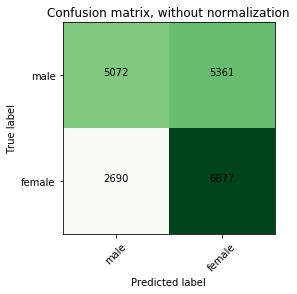

In [23]:
plot_confusion_matrix_version2(cm, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

In [24]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test_gender, predicted_gender)

0.59745

In [25]:
print(classification_report(y_test_gender, predicted_gender))

              precision    recall  f1-score   support

           0       0.65      0.49      0.56     10433
           1       0.56      0.72      0.63      9567

   micro avg       0.60      0.60      0.60     20000
   macro avg       0.61      0.60      0.59     20000
weighted avg       0.61      0.60      0.59     20000



## Classifier Age

In [26]:
def classify_age(text):
    return '30s'

In [27]:
classifier_age = MultinomialNB()
classifier_age.fit(X_train, y_train_age)

score = classifier_age.score(X_test, y_test_age)

print("Accuracy:", score)

Accuracy: 0.59255


In [28]:
predicted_age = classifier_age.predict(X_test)

In [29]:
accuracy_score(y_test_age, predicted_age)

0.59255

In [30]:
cm = confusion_matrix(y_test_age, predicted_age)

In [31]:
cm

array([[  242,   217,  2719],
       [   42,  1301,  4654],
       [   71,   446, 10308]])

In [32]:
class_names = ['10s', '20s', '30s']

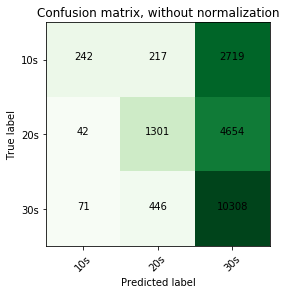

In [33]:
plot_confusion_matrix_version2(cm, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

In [34]:
print(classification_report(y_test_age, predicted_age))

              precision    recall  f1-score   support

           1       0.68      0.08      0.14      3178
           2       0.66      0.22      0.33      5997
           3       0.58      0.95      0.72     10825

   micro avg       0.59      0.59      0.59     20000
   macro avg       0.64      0.42      0.40     20000
weighted avg       0.62      0.59      0.51     20000



## Classifier gender and age combined

In [35]:
classifier_gender_and_age = MultinomialNB()
classifier_gender_and_age.fit(X_train, y_train_gender_and_age)

score = classifier_gender_and_age.score(X_test, y_test_gender_and_age)

print("Accuracy:", score)

Accuracy: 0.3628


In [36]:
predicted_gender_and_age = classifier_gender_and_age.predict(X_test)

In [37]:
accuracy_score(y_test_gender_and_age, predicted_gender_and_age)

0.3628

In [38]:
cm = confusion_matrix(y_test_gender_and_age, predicted_gender_and_age)
cm

array([[ 129,   69,   77,    6,    6, 1671],
       [  10,  649,  382,    4,   43, 2532],
       [  11,  126,  791,    5,   15, 3907],
       [  11,   79,   48,   25,    5, 1052],
       [   5,  182,  151,    4,  116, 1919],
       [  15,   92,  290,    5,   22, 5546]])

In [39]:
class_names = ['male_10s', 'male_20s', 'male_30s', 'female_10s', 'female_20s', 'female_30s']

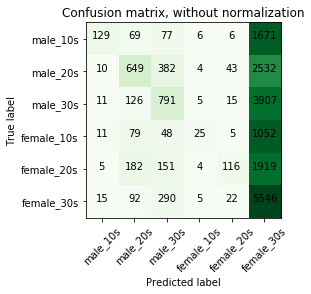

In [40]:
plot_confusion_matrix_version2(cm, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

In [41]:
print(classification_report(y_test_gender_and_age, predicted_age))

              precision    recall  f1-score   support

           1       0.48      0.09      0.15      1958
           2       0.44      0.24      0.31      3620
           3       0.26      0.95      0.41      4855
           4       0.00      0.00      0.00      1220
           5       0.00      0.00      0.00      2377
           6       0.00      0.00      0.00      5970

   micro avg       0.28      0.28      0.28     20000
   macro avg       0.20      0.21      0.14     20000
weighted avg       0.19      0.28      0.17     20000



/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Predictions on the dummy test data

In [66]:
test_messages = pd.read_csv('dummy_test.csv', sep=',')

##### uncomment following code if text contains html! #####

#test_messages['text'] = test_messages['text'].apply(clean_text)

## Gender prediction

In [67]:
def classify_on_dummy_data_gender(dummy_data):
    """Classifies the given text dataset. Prints the confusion matrix and a classification report

    Args:
      dummy_data: dataset with texts
    """
    X_test = dummy_data['text'].values
    X_test = vectorizer.transform(X_test)
    
    y_test_gender = numeric_label_setting_for_gender(dummy_data['person_gender'].values)
    y_test_gender = y_test_gender.astype('int')
    
    predicted_gender = classifier_gender.predict(X_test)
    
    cm = confusion_matrix(y_test_gender, predicted_gender)
    plot_confusion_matrix_version2(cm, classes=class_names,
                      title='Confusion matrix, without normalization')
    plt.show()
    print('Classification report: \n\n', classification_report(y_test_gender, predicted_gender))
    print('Accuracy:', accuracy_score(y_test_gender, predicted_gender))

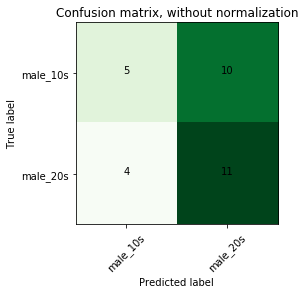

Classification report: 

               precision    recall  f1-score   support

           0       0.56      0.33      0.42        15
           1       0.52      0.73      0.61        15

   micro avg       0.53      0.53      0.53        30
   macro avg       0.54      0.53      0.51        30
weighted avg       0.54      0.53      0.51        30

Accuracy: 0.5333333333333333


In [68]:
classify_on_dummy_data_gender(test_messages)

## Age prediction

In [69]:
def classify_on_dummy_data_age(dummy_data):
    """Classifies the given text dataset. Prints the confusion matrix and a classification report

    Args:
      dummy_data: dataset with texts
    """
    X_test = dummy_data['text'].values
    X_test = vectorizer.transform(X_test)
  
    
    y_test_age = numeric_label_setting_for_age(dummy_data['person_age'].values)
    y_test_age = y_test_age.astype('int')
    
    predicted_age = classifier_age.predict(X_test)
    
    cm = confusion_matrix(y_test_age, predicted_age)
    class_names = ['10s', '20s', '30s']
    plot_confusion_matrix_version2(cm, classes=class_names,
                      title='Confusion matrix, without normalization')
    plt.show()
    print('Classification report: \n\n', classification_report(y_test_age, predicted_age))
    print('Accuracy:', accuracy_score(y_test_age, predicted_age))

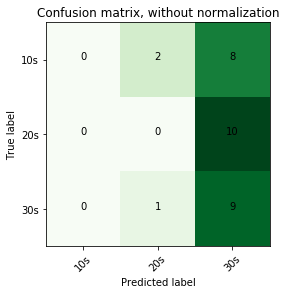

Classification report: 

               precision    recall  f1-score   support

           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.33      0.90      0.49        10

   micro avg       0.30      0.30      0.30        30
   macro avg       0.11      0.30      0.16        30
weighted avg       0.11      0.30      0.16        30

Accuracy: 0.3


In [70]:
classify_on_dummy_data_age(test_messages)

## Gender and age combined prediction

In [71]:
def classify_on_dummy_data_gender_and_age(dummy_data):
    """Classifies the given text dataset. Prints the confusion matrix and a classification report

    Args:
      dummy_data: dataset with texts
    """
    X_test = dummy_data['text'].values
    X_test = vectorizer.transform(X_test)
  
    
    y_test_gender_and_age = numeric_label_setting_for_gender_and_age(dummy_data['person_gender'].values, 
                                                            dummy_data['person_age'].values)
    y_test_gender_and_age = y_test_gender_and_age.astype('int')
    
    predicted_gender_and_age = classifier_gender_and_age.predict(X_test)   
    
    cm = confusion_matrix(y_test_gender_and_age, predicted_gender_and_age)
    class_names = ['male_10s', 'male_20s', 'male_30s', 'female_10s', 'female_20s', 'female_30s']    
    plot_confusion_matrix_version2(cm, classes=class_names,
                      title='Confusion matrix, without normalization')
    plt.show()
    print('Classification report: \n\n', classification_report(y_test_gender_and_age, predicted_gender_and_age))
    print('Accuracy:', accuracy_score(y_test_gender_and_age, predicted_gender_and_age))

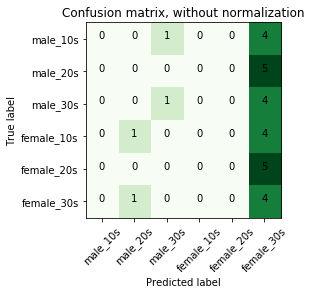

Classification report: 

               precision    recall  f1-score   support

           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         5
           3       0.50      0.20      0.29         5
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         5
           6       0.15      0.80      0.26         5

   micro avg       0.17      0.17      0.17        30
   macro avg       0.11      0.17      0.09        30
weighted avg       0.11      0.17      0.09        30

Accuracy: 0.16666666666666666


In [72]:
classify_on_dummy_data_gender_and_age(test_messages)